---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

In [26]:
! pip install split-folders
! pip install torchsummary

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch
import numpy as np 
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
data_dir="/data/landmark_images"
CenterCrop=256
Resize=256
BatchSize=32
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_transforms = transforms.Compose([transforms.Resize(Resize),
                                       transforms.CenterCrop(CenterCrop),
                                       #transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(p=0.3), 
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)])

                                                           

test_transforms = transforms.Compose([transforms.Resize(Resize),
                                 transforms.CenterCrop(CenterCrop),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean,std)])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

validation_split = .2
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

loaders_scratch = {'train':  torch.utils.data.DataLoader(train_data, batch_size=BatchSize,sampler=train_sampler),
                   'valid':  torch.utils.data.DataLoader(train_data, batch_size=BatchSize,sampler=valid_sampler), 
                   'test':  torch.utils.data.DataLoader(test_data, batch_size=BatchSize)}
p=iter(loaders_scratch["train"])
p,_=next(p)
print(p.shape)

torch.Size([32, 3, 256, 256])


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
* I start with 32  Resize and crop to make sure the model training to  get the best but minimal details of the landmark , ii examed  the picture with  my eyes  and  increased it until i was satisfied with the i also compare it with pre trained models VGG   

* Yes i did , * for Agnation i used the rotate + Flip to Avoid overfitting of training images  
  the flip can confuse the model about location detecetion as it look diffrent picture and noramly is not shoud be exists in the reality


### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(loaders_scratch["train"])
classes = train_data.classes
images, labels = next(dataiter)
#images = images.numpy() 
mean = np.array(mean)
std = np.array(std)


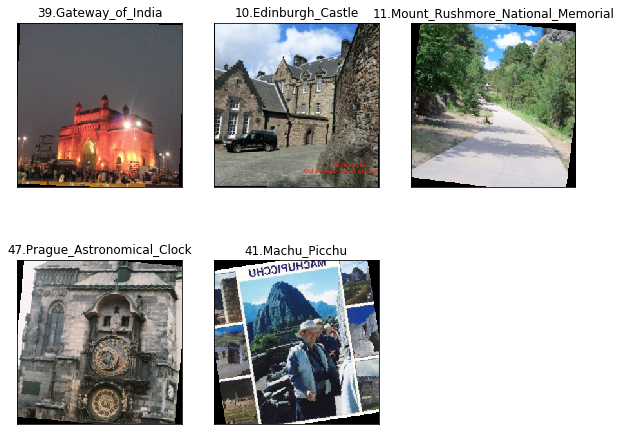

In [3]:

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)


# convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 8))
for idx in np.arange(5):
   # img = unnormlize(images[idx], torch.Tensor(std), torch.Tensor(mean))
    image = images[idx].numpy().transpose((1, 2, 0))
     #
    image = std * image + mean
    #image = np.clip(image,0, 1)
    ax = fig.add_subplot(2, 3, idx+1, xticks=[], yticks=[])
    ax.imshow(image)
    ax.set_title(classes[labels[idx]])



In [4]:
images.shape

torch.Size([32, 3, 256, 256])

### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function
from torch import optim
#criterion_scratch = nn.NLLLoss()
criterion_scratch=nn.CrossEntropyLoss()


def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer =   optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn as nn
#For Each MaxPuul device by 2
FlatSize=64*(int(CenterCrop/2/2/2)**2)
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.fc1 = nn.Linear(FlatSize, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 50)
        self.dropout = nn.Dropout(0.4) 
    

        ## Define layers of a CNN

        
        
    
    def forward(self, x):
        ## Define forward behavior
        #print("Before CNN",x.shape)
        x=F.relu(self.conv1_1(x))
        
        x = self.pool(x)
       
        x=F.relu(self.conv2_1(x))
        
        x = self.pool(x)
       
        x=F.relu(self.conv3_1(x))
      
        x = self.pool(x)

        x = x.view(-1, FlatSize)

        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
       
        x = self.dropout(x)
      
        x = self.fc2(x)
        
        x = self.dropout(x)
        
        x = self.fc3(x)
 
        return x
        
        
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
model_scratch.to(device)

Net(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=50, bias=True)
  (dropout): Dropout(p=0.4)
)

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__   Conventional layer Conv 1,2,3  I  followed the examples we had during class room also the VGG ,
I tried also deeper but it seems processing time consuming , so i decided to go with minimum and exam the results , and indeed the results was satisfying 
   I choose tried also several Optimize methos and LR as well until i got the optimum for my training case 
I choose the CrossEntropyLoss as it is got best practices for Classifiaction classes as it provide the probability for each class among the 100% of all classes 


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            
            data, target = data.to(device) ,target.to(device)

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            #print(output.shape)
            #print(target.shape)
             # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
             # update training loss
            train_loss +=  ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            
              data, target = data.to(device), target.to(device)

            ## TODO: update average validation loss 

              output = model(data)
              loss = criterion(output, target)
            # update average validation loss 
              valid_loss +=  (loss.data.item() - valid_loss)*1 / (batch_idx + 1)
   
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), save_path)
          valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [36]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
    
use_cuda=device   

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.910773 	Validation Loss: 3.908985
Validation loss decreased (inf --> 3.908985).  Saving model ...
Epoch: 2 	Training Loss: 3.904650 	Validation Loss: 3.903605
Validation loss decreased (3.908985 --> 3.903605).  Saving model ...
Epoch: 3 	Training Loss: 3.893251 	Validation Loss: 3.886593
Validation loss decreased (3.903605 --> 3.886593).  Saving model ...
Epoch: 4 	Training Loss: 3.865547 	Validation Loss: 3.846869
Validation loss decreased (3.886593 --> 3.846869).  Saving model ...
Epoch: 5 	Training Loss: 3.813685 	Validation Loss: 3.802455
Validation loss decreased (3.846869 --> 3.802455).  Saving model ...
Epoch: 6 	Training Loss: 3.757761 	Validation Loss: 3.747390
Validation loss decreased (3.802455 --> 3.747390).  Saving model ...
Epoch: 7 	Training Loss: 3.696774 	Validation Loss: 3.678133
Validation loss decreased (3.747390 --> 3.678133).  Saving model ...
Epoch: 8 	Training Loss: 3.637471 	Validation Loss: 3.609327
Validation loss decreased (3.67813

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [11]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 21
use_cuda=device

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.882975 	Validation Loss: 3.756683
Validation loss decreased (inf --> 3.756683).  Saving model ...
Epoch: 2 	Training Loss: 3.708936 	Validation Loss: 3.547304
Validation loss decreased (3.756683 --> 3.547304).  Saving model ...
Epoch: 3 	Training Loss: 3.531107 	Validation Loss: 3.376172
Validation loss decreased (3.547304 --> 3.376172).  Saving model ...
Epoch: 4 	Training Loss: 3.365507 	Validation Loss: 3.222193
Validation loss decreased (3.376172 --> 3.222193).  Saving model ...
Epoch: 5 	Training Loss: 3.232086 	Validation Loss: 3.171640
Validation loss decreased (3.222193 --> 3.171640).  Saving model ...
Epoch: 6 	Training Loss: 3.125532 	Validation Loss: 3.097132
Validation loss decreased (3.171640 --> 3.097132).  Saving model ...
Epoch: 7 	Training Loss: 3.057438 	Validation Loss: 3.032593
Validation loss decreased (3.097132 --> 3.032593).  Saving model ...
Epoch: 8 	Training Loss: 2.971434 	Validation Loss: 2.939847
Validation loss decreased (3.03259

KeyboardInterrupt: 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [1]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))




In [9]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.683971


Test Accuracy: 34% (427/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch
import numpy as np 
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
data_dir="/data/landmark_images"
CenterCrop=224
Resize=255
BatchSize=32
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


train_transforms = transforms.Compose([transforms.Resize(Resize),
                                       transforms.CenterCrop(CenterCrop),
                                       transforms.RandomHorizontalFlip(p=0.3), 
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)])

                                                           

test_transforms = transforms.Compose([transforms.Resize(Resize),
                                 transforms.CenterCrop(CenterCrop),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean,std)])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

validation_split = .2
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

loaders_transfer = {'train':  torch.utils.data.DataLoader(train_data, batch_size=BatchSize,sampler=train_sampler),
                   'valid':  torch.utils.data.DataLoader(train_data, batch_size=BatchSize,sampler=valid_sampler), 
                   'test':  torch.utils.data.DataLoader(test_data, batch_size=BatchSize)}
p=iter(loaders_transfer["train"])
p,_=next(p)
print(p.shape)

torch.Size([32, 3, 224, 224])


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [2]:
## TODO: select loss function
from torch import optim
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer =   optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [3]:
## TODO: Specify model architecture
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
model_transfer = models.vgg16(pretrained=True)

#freezing features- weights
for param in model_transfer.features.parameters():
    param.require_grad =False
#change the last full connected  layer to fit the no of classes
classes = train_data.classes
model_transfer.classifier[6] = nn.Linear( model_transfer.classifier[6].in_features , len(classes) )

model_transfer.to(device)


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()
model_transfer

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 114508946.49it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  I choose the VGG16 after read about the pre trained model ,first the size of input image resolution which is trained on  which is important to me as i explained in the first answer about the minimum resolution  
Freezing the feature parameters, is to avoid the processing  the feature grad backward as it trained already , also the fully-connected nodes  seems promising and deep i used the best practics of "small set, different data!   


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [8]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
model_transfer=train(10, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                    criterion_transfer, use_cuda, 'model_transfer.pt')
  

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy


Epoch: 1 	Training Loss: 2.670171 	Validation Loss: 1.760919
Validation loss decreased (inf --> 1.760919).  Saving model ...
Epoch: 2 	Training Loss: 1.447373 	Validation Loss: 1.338717
Validation loss decreased (1.760919 --> 1.338717).  Saving model ...
Epoch: 3 	Training Loss: 0.983666 	Validation Loss: 1.265358
Validation loss decreased (1.338717 --> 1.265358).  Saving model ...
Epoch: 4 	Training Loss: 0.757416 	Validation Loss: 1.202176
Validation loss decreased (1.265358 --> 1.202176).  Saving model ...
Epoch: 5 	Training Loss: 0.585060 	Validation Loss: 1.294066
Epoch: 6 	Training Loss: 0.413306 	Validation Loss: 1.267962
Epoch: 7 	Training Loss: 0.318347 	Validation Loss: 1.401998
Epoch: 8 	Training Loss: 0.289237 	Validation Loss: 1.454287
Epoch: 9 	Training Loss: 0.216592 	Validation Loss: 1.393175
Epoch: 10 	Training Loss: 0.196255 	Validation Loss: 1.525085


In [4]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [12]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.017361


Test Accuracy: 76% (962/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [5]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image = Image.open(img_path)
    CenterCrop=224
    Resize=255
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize(Resize),
                                 transforms.CenterCrop(CenterCrop),
                                 transforms.ToTensor(),
                                  normalize])
    
    image= transform(image)
    image.unsqueeze_(0)
  
    if use_cuda:
        image = image.cuda()
        
    model_transfer.eval()  
                                    
    output = model_transfer(image)
    values, indices = output.topk(k)
    top_k_classes = []
    
    for i in indices[0].tolist():
        top_k_classes.append(classes[i])

    model_transfer.train()
    
    return top_k_classes    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['09.Golden_Gate_Bridge',
 '30.Brooklyn_Bridge',
 '38.Forth_Bridge',
 '28.Sydney_Harbour_Bridge',
 '33.Sydney_Opera_House']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

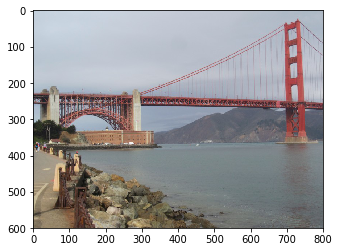

Actual Label: Golden Gate Bridge
 The top 3 prediction lables from hight to low probebelity :
0) 09.Golden_Gate_Bridge
1) 30.Brooklyn_Bridge
2) 38.Forth_Bridge


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()
    print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ').split('.')[0]}")
    all_labels = [predicted_landmarks[i] for i in range(3)]
    print(f" The top 3 prediction lables from hight to low probebelity :")
    for i in range(3):
       print(f"{i}) {all_labels[i]}")
    
 
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:The results are awesome 73% is more then i expected and the example of my test below with prediction of 4 examples are 100% all 4 
To improve the model, we need to add more images as 100 images per class its really few i this this by it self could improve the train singingly  
Other that for example add full connected layer will probably end with overfitting as we got above,
I would try other augmentations kind to extend the variety of images or clone them let the augmentation to make the variance again       


In [3]:
!ls images/test

03.Dead_Sea			     16.Eiffel_Tower  41.Machu_Picchu
09.Golden_Gate_Bridge		     24.Soreq_Cave    45.Temple_of_Heaven
11.Mount_Rushmore_National_Memorial  37.Atomium


In [7]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
base_path="images/test/"
images_path=["45.Temple_of_Heaven/2af4218fe2a1f900.jpg",
              "16.Eiffel_Tower/5ad80dcbdbba91b6.jpg",
               "11.Mount_Rushmore_National_Memorial/45a594975e682ff3.jpg",
              "03.Dead_Sea/33709788061354b1.jpg"]


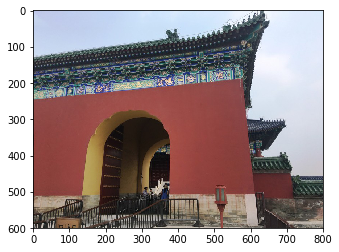

Actual Label: Temple of Heaven
 The top 3 prediction lables from hight to low probebelity :
0) 45.Temple_of_Heaven
1) 39.Gateway_of_India
2) 17.Changdeokgung


In [9]:
suggest_locations(base_path+images_path[0])


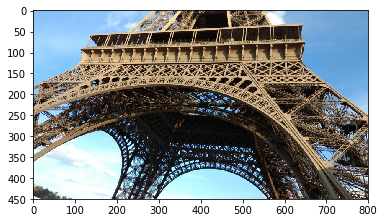

Actual Label: Eiffel Tower
 The top 3 prediction lables from hight to low probebelity :
0) 16.Eiffel_Tower
1) 28.Sydney_Harbour_Bridge
2) 30.Brooklyn_Bridge


In [10]:
suggest_locations(base_path+images_path[1])


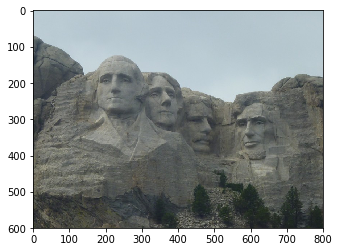

Actual Label: Mount Rushmore National Memorial
 The top 3 prediction lables from hight to low probebelity :
0) 11.Mount_Rushmore_National_Memorial
1) 41.Machu_Picchu
2) 23.Externsteine


In [11]:
suggest_locations(base_path+images_path[2])

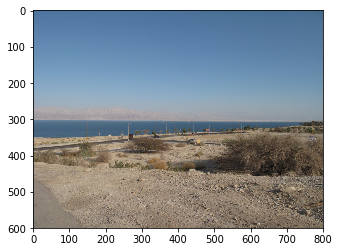

Actual Label: Dead Sea
 The top 3 prediction lables from hight to low probebelity :
0) 03.Dead_Sea
1) 36.Badlands_National_Park
2) 13.Yellowstone_National_Park


In [12]:
suggest_locations(base_path+images_path[3])